<h1><b><i>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; RetinaNet on GTSRB Dataset</i></b></h1> 

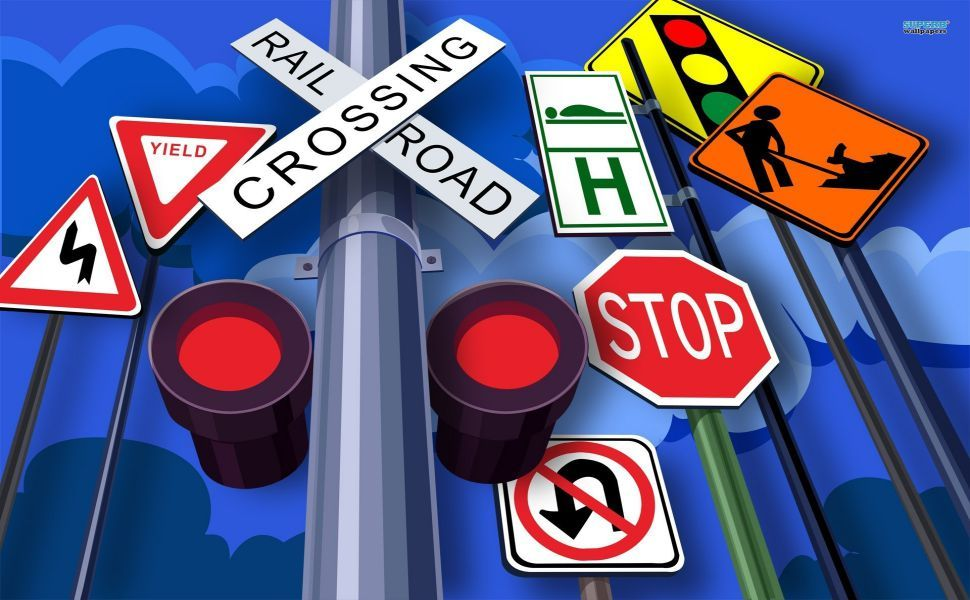

In [ ]:
from IPython.display import Image
Image('/content/TrafficSignal.jpg', width=1200)

# 1. Business/ Real-world constraints :

## 1.1. Problem Statement :

<p>
• Traffic signs are an integral part of our road infrastructure. Without such useful signs, 
we would most likely be faced with more accidents, as drivers would not be given critical 
feedback on how fast they could safely go, or informed about road works, sharp turn, or 
school crossings ahead.
<br><br>
• Naturally, autonomous vehicles must also abide by road legislation and therefore recognize and understand traffic signs.
<br><br>
• The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held 
at the International Joint Conference on Neural Networks (IJCNN) 2011.
</p>

## 1.2. Objectives and constraints :

• Each traffic sign should be correctly identified. Hence, multi-class log-loss should be improved.
<br><br>
• Also, time is a major constraint here because a delay of even a second can be a matter of life and death.<br>

## 1.3. Useful References :

• <a href="http://benchmark.ini.rub.de/?section=home&subsection=news">INI Benchmark Website</a>
<br><br>
• <a href="https://cg.cs.tsinghua.edu.cn/traffic-sign/">Traffic sign detection and classification in the wild</a>
<br><br>
• <a href="https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign">Kaggle page to download the dataset</a>
<br><br>

• <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html">Building a very powerful image classification model with very little data</a>
<br><br>

# *   RetinaNet

*   In this notebook, i will be using RetinaNet Model.
*   Refer this [link](https://medium.com/@14prakash/the-intuition-behind-retinanet-eb636755607d) to learn more about RetinaNet.
*   Keras RetinaNet can be cloned from this [github repo](https://github.com/fizyr/keras-retinanet).






In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
#Importing essential libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import files
import os, random, math, shutil, pathlib, urllib
from tensorflow.keras.callbacks import TensorBoard

### Downloading dataset from kaggle :

In [3]:
def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print('Please upload the kaggle api token :')
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

In [4]:
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle.json
kaggle.json
100% 609M/612M [00:16<00:00, 43.1MB/s]
100% 612M/612M [00:16<00:00, 39.6MB/s]


### Creating Train and Validation annotations files and the class - index mapping file :

In [5]:
#Train annotations
ANNOTATIONS_FILE = "/content/annotations.csv"
new_df_train = pd.read_csv("/content/Data/Train.csv")
with open(ANNOTATIONS_FILE, 'w') as f :
  for i in tqdm(range(new_df_train.shape[0])) :
    f.write("{},{},{},{},{},{}\n".format("/content/Data/" + new_df_train.iloc[i]['Path'], 
                                         str(new_df_train.iloc[i]['Roi.X1']), str(new_df_train.iloc[i]['Roi.Y1']), 
                                         str(new_df_train.iloc[i]['Roi.X2']), str(new_df_train.iloc[i]['Roi.Y2']), str(new_df_train.iloc[i]['ClassId'])))

100%|██████████| 39209/39209 [00:55<00:00, 711.85it/s]


In [6]:
CLASS_FILE = "/content/classes.csv"
class_names = list(range(43))

with open(CLASS_FILE, 'w') as f :
  for i, cn in enumerate(class_names) :
    f.write("{},{}\n".format(cn, i))

### Cloning keras-retinanet repo from github :

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [3]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169694 sha256=dcdb659ff51096287f52bd864a50b84e887d5065cf9514c0ac67d73908b94174
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [4]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


### Downloading pretrained model :

In [5]:
#Downloading pretrained model
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = "https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5"
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


### Training :

In [ ]:
!/content/keras-retinanet/keras_retinanet/bin/train.py --weights {PRETRAINED_MODEL} --weighted-average --multiprocessing --steps 100 --tensorboard-dir /content/tensorboard_dir --epochs 200 csv /content/annotations.csv /content/classes.csv

Using TensorFlow backend.
2020-06-27 07:04:35.581747: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-06-27 07:04:40.047834: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-27 07:04:40.114141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-27 07:04:40.114804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-27 07:04:40.114853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-

In [6]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

Using TensorFlow backend.


In [7]:
THRES_SCORE = 0.5
model_path = "/content/drive/My Drive/CaseStudy2/resnet50_csv_51.h5"
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv("/content/classes.csv",header=None).T.loc[0].to_dict()

/content/drive/My Drive/CaseStudy2/resnet50_csv_51.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.3174

In [49]:
def img_inference(img_path):
  image = read_image_bgr(img_path)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)
  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  # correct for image scale
  boxes /= scale
  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
        return -1, -1, -1
      else :
        return img_path[14:], labels_to_names[label], box

In [47]:
test_df = pd.read_csv("/content/Data/Test.csv")

In [50]:
from tqdm import tqdm
img_names = []
labels = []
boxes = []
for itr in tqdm(range(test_df.shape[0])) :
  n, l, b = img_inference("/content/Data/" + test_df.iloc[itr]['Path'])
  img_names.append(n)
  labels.append(l)
  boxes.append(b)

100%|██████████| 12630/12630 [12:11<00:00, 17.26it/s]


In [51]:
x1 = []
y1 = []
x2 = []
y2 = []
for b in tqdm(boxes) :
  if type(b) == np.ndarray :
    x1.append(b[0])
    y1.append(b[1])
    x2.append(b[2])
    y2.append(b[3])

100%|██████████| 12630/12630 [00:00<00:00, 1568486.40it/s]


In [52]:
pred_test = pd.DataFrame(data=list(zip(img_names, labels, x1, y1, x2, y2)), columns=['Path', 'pred_labels', 'x1_pred', 'y1_pred', 'x2_pred', 'y2_pred'])

In [64]:
pred_test = pd.read_csv("/content/drive/My Drive/CaseStudy2/retinanet_pred_final.csv")
pred_test = pred_test.drop('Unnamed: 0', axis = 1)
final_df = pd.merge(test_df, pred_test, on='Path', how='inner')

In [62]:
actual = final_df['ClassId']
pred = final_df['pred_labels']
from sklearn.metrics import f1_score
print("Test F1-Score : {0:0.2f}".format(f1_score(actual, pred, average='weighted')))

Test F1-Score : 0.87


In [63]:
from sklearn.metrics import mean_squared_error
print("Test MSE : {0:0.2f}".format(mean_squared_error(final_df.iloc[:, 2:6], final_df.iloc[:, 9:])))

Test MSE : 505.74
